In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

Wed Dec 28 02:57:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    31W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
import gc

tf.compat.v1.disable_eager_execution()

def normalize(x):
        """Utility function to normalize a tensor by its L2 norm"""
        return (x + 1e-10) / (K.sqrt(K.mean(K.square(x))) + 1e-10)


def GradCamPlusPlus(model, img_array, layer_name):
    cls = np.argmax(model.predict(img_array))
    y_c = model.output[0, cls]
    conv_output = model.get_layer(layer_name).output
    grads = tf.gradients(y_c, conv_output)[0]

    first = K.exp(y_c)*grads
    second = K.exp(y_c)*grads*grads
    third = K.exp(y_c)*grads*grads*grads

    gradient_function = K.function([model.input], [y_c,first,second,third, conv_output, grads])
    y_c, conv_first_grad, conv_second_grad,conv_third_grad, conv_output, grads_val = gradient_function([img_array])
    global_sum = np.sum(conv_output[0].reshape((-1,conv_first_grad[0].shape[2])), axis=0)

    alpha_num = conv_second_grad[0]
    alpha_denom = conv_second_grad[0]*2.0 + conv_third_grad[0]*global_sum.reshape((1,1,conv_first_grad[0].shape[2]))
    alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, np.ones(alpha_denom.shape))
    alphas = alpha_num/alpha_denom

    weights = np.maximum(conv_first_grad[0], 0.0)
    alpha_normalization_constant = np.sum(np.sum(alphas, axis=0),axis=0)
    alphas /= alpha_normalization_constant.reshape((1,1,conv_first_grad[0].shape[2]))
    deep_linearization_weights = np.sum((weights*alphas).reshape((-1,conv_first_grad[0].shape[2])),axis=0)

    cam = np.sum(deep_linearization_weights*conv_output[0], axis=2)
    cam = np.maximum(cam, 0)  # Passing through ReLU
    cam /= np.max(cam) # scale 0 to 1.0  

    return cam

def softmax(x):
    f = np.exp(x)/np.sum(np.exp(x), axis = 1, keepdims = True)
    return f

def ScoreCam(model, img_array, layer_name, max_N=-1):

    cls = np.argmax(model.predict(img_array))
    act_map_array = Model(inputs=model.input, outputs=model.get_layer(layer_name).output).predict(img_array)
    
    # extract effective maps
    if max_N != -1:
        act_map_std_list = [np.std(act_map_array[0,:,:,k]) for k in range(act_map_array.shape[3])]
        unsorted_max_indices = np.argpartition(-np.array(act_map_std_list), max_N)[:max_N]
        max_N_indices = unsorted_max_indices[np.argsort(-np.array(act_map_std_list)[unsorted_max_indices])]
        act_map_array = act_map_array[:,:,:,max_N_indices]

    input_shape = model.layers[0].output_shape[0][1:]  # get input shape
    # 1. upsampled to original input size
    act_map_resized_list = [cv2.resize(act_map_array[0,:,:,k], input_shape[:2], interpolation=cv2.INTER_LINEAR) for k in range(act_map_array.shape[3])]
    # 2. normalize the raw activation value in each activation map into [0, 1]
    act_map_normalized_list = []
    for act_map_resized in act_map_resized_list:
        if np.max(act_map_resized) - np.min(act_map_resized) != 0:
            act_map_normalized = act_map_resized / (np.max(act_map_resized) - np.min(act_map_resized))
        else:
            act_map_normalized = act_map_resized
        act_map_normalized_list.append(act_map_normalized)
    # 3. project highlighted area in the activation map to original input space by multiplying the normalized activation map
    masked_input_list = []
    for act_map_normalized in act_map_normalized_list:
        masked_input = np.copy(img_array)
        for k in range(3):
            masked_input[0,:,:,k] *= act_map_normalized
        masked_input_list.append(masked_input)
    masked_input_array = np.concatenate(masked_input_list, axis=0)
    # 4. feed masked inputs into CNN model and softmax
    pred_from_masked_input_array = softmax(model.predict(masked_input_array))
    # 5. define weight as the score of target class
    weights = pred_from_masked_input_array[:,cls]
    # 6. get final class discriminative localization map as linear weighted combination of all activation maps
    cam = np.dot(act_map_array[0,:,:,:], weights)
    cam = np.maximum(0, cam)  # Passing through ReLU
    cam /= np.max(cam)  # scale 0 to 1.0
    
    return cam

def superimpose(original_img_path, cam, emphasize=False):
    
    img_bgr = cv2.imread(original_img_path)

    heatmap = cv2.resize(cam, (img_bgr.shape[1], img_bgr.shape[0]))
    if emphasize:
        heatmap = sigmoid(heatmap, 50, 0.5, 1)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    hif = .8
    superimposed_img = heatmap * hif + img_bgr
    superimposed_img = np.minimum(superimposed_img, 255.0).astype(np.uint8)  # scale 0 to 255  
    superimposed_img_rgb = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
    
    return superimposed_img_rgb

import tensorflow.keras

import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.keras.applications.vgg16 import preprocess_input


def sigmoid(x, a, b, c):
    return c / (1 + np.exp(-a * (x-b)))

from tensorflow.keras.preprocessing.image import load_img, img_to_array

def read_and_preprocess_img(path, size=(299,299)):
    img = load_img(path, target_size=size)
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

## Compare Grad-CAM++, Score-CAM

In [4]:
from tensorflow.keras.preprocessing.image import load_img
#from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.applications.xception import Xception, preprocess_input, decode_predictions

from tensorflow.keras.applications import Xception
import matplotlib.pyplot as plt
import cv2
import numpy as np

def build_Xception():
    return Xception(include_top=True, weights='imagenet')

model = build_Xception()

Instructions for updating:
Colocations handled automatically by placer.


91884032/91884032 [==============================] - 0s 0us/step


In [5]:
model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


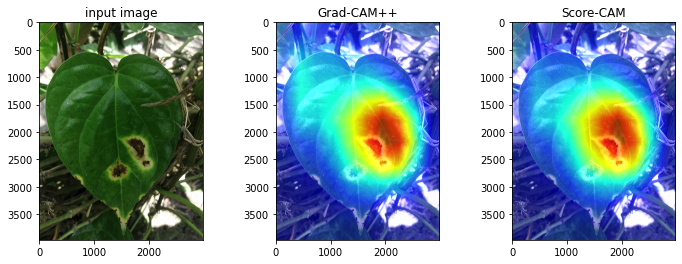

In [6]:

layer_name = 'block14_sepconv2_act'

#img_path = '/content/drive/MyDrive/bird.jpg'
img_path = '/content/drive/MyDrive/Betel Leaf/Train/Unhealthy Betel Leaf/IMG_20220711_112110.jpg'
orig_img = np.array(load_img(img_path),dtype=np.uint8)
img_array = read_and_preprocess_img(img_path, size=(299,299))

# predictions = model.predict(img_array)
# top = decode_predictions(predictions, top=5)[0]
# print(img_path)
# print("class activation map for:",top[0])

grad_cam_plus_plus=GradCamPlusPlus(model,img_array,layer_name)
grad_cam_plus_plus_superimposed = superimpose(img_path, grad_cam_plus_plus)

score_cam=ScoreCam(model,img_array,layer_name)
score_cam_superimposed = superimpose(img_path, score_cam)

fig, ax = plt.subplots(nrows=1,ncols=3, figsize=(12, 4))
ax[0].imshow(orig_img)
ax[0].set_title("input image")
ax[1].imshow(grad_cam_plus_plus_superimposed)
ax[1].set_title("Grad-CAM++")
ax[2].imshow(score_cam_superimposed)
ax[2].set_title("Score-CAM")

plt.show()

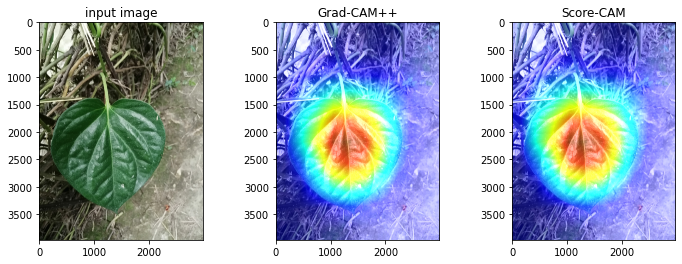

In [7]:

layer_name = 'block14_sepconv2_act'

#img_path = '/content/drive/MyDrive/bird.jpg'
img_path = '/content/drive/MyDrive/Betel Leaf/Train/Healthy Betel Leaf/IMG_20220717_104223.jpg'
orig_img = np.array(load_img(img_path),dtype=np.uint8)
img_array = read_and_preprocess_img(img_path, size=(299,299))

# predictions = model.predict(img_array)
# top = decode_predictions(predictions, top=5)[0]
# print(img_path)
# print("class activation map for:",top[0])

grad_cam_plus_plus=GradCamPlusPlus(model,img_array,layer_name)
grad_cam_plus_plus_superimposed = superimpose(img_path, grad_cam_plus_plus)

score_cam=ScoreCam(model,img_array,layer_name)
score_cam_superimposed = superimpose(img_path, score_cam)

fig, ax = plt.subplots(nrows=1,ncols=3, figsize=(12, 4))
ax[0].imshow(orig_img)
ax[0].set_title("input image")
ax[1].imshow(grad_cam_plus_plus_superimposed)
ax[1].set_title("Grad-CAM++")
ax[2].imshow(score_cam_superimposed)
ax[2].set_title("Score-CAM")

plt.show()

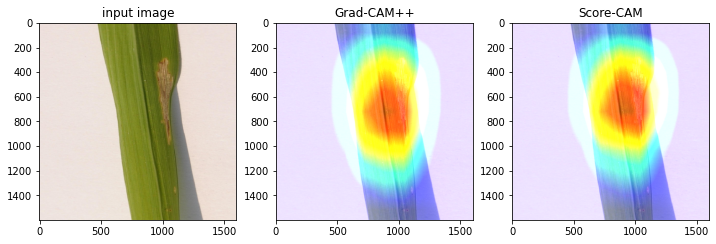

In [19]:

layer_name = 'block14_sepconv2_act'

#img_path = '/content/drive/MyDrive/bird.jpg'
img_path = '/content/drive/MyDrive/RiceLeaf/train/bacterial_leaf_blight/bacterial_leaf_blight (4).JPG'
orig_img = np.array(load_img(img_path),dtype=np.uint8)
img_array = read_and_preprocess_img(img_path, size=(299,299))

# predictions = model.predict(img_array)
# top = decode_predictions(predictions, top=5)[0]
# print(img_path)
# print("class activation map for:",top[0])

grad_cam_plus_plus=GradCamPlusPlus(model,img_array,layer_name)
grad_cam_plus_plus_superimposed = superimpose(img_path, grad_cam_plus_plus)

score_cam=ScoreCam(model,img_array,layer_name)
score_cam_superimposed = superimpose(img_path, score_cam)

fig, ax = plt.subplots(nrows=1,ncols=3, figsize=(12, 4))
ax[0].imshow(orig_img)
ax[0].set_title("input image")
ax[1].imshow(grad_cam_plus_plus_superimposed)
ax[1].set_title("Grad-CAM++")
ax[2].imshow(score_cam_superimposed)
ax[2].set_title("Score-CAM")

plt.show()

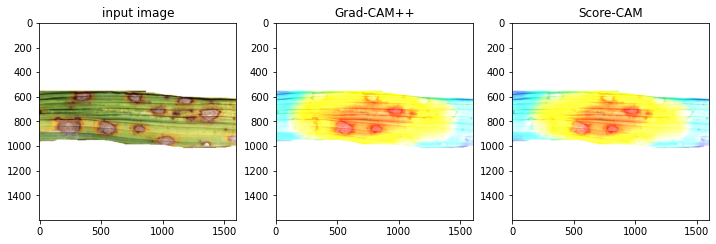

In [24]:

layer_name = 'block14_sepconv2_act'

#img_path = '/content/drive/MyDrive/bird.jpg'
img_path = '/content/drive/MyDrive/RiceLeaf/train/brown_spot/brown_spot (26).jpg'
orig_img = np.array(load_img(img_path),dtype=np.uint8)
img_array = read_and_preprocess_img(img_path, size=(299,299))

# predictions = model.predict(img_array)
# top = decode_predictions(predictions, top=5)[0]
# print(img_path)
# print("class activation map for:",top[0])

grad_cam_plus_plus=GradCamPlusPlus(model,img_array,layer_name)
grad_cam_plus_plus_superimposed = superimpose(img_path, grad_cam_plus_plus)

score_cam=ScoreCam(model,img_array,layer_name)
score_cam_superimposed = superimpose(img_path, score_cam)

fig, ax = plt.subplots(nrows=1,ncols=3, figsize=(12, 4))
ax[0].imshow(orig_img)
ax[0].set_title("input image")
ax[1].imshow(grad_cam_plus_plus_superimposed)
ax[1].set_title("Grad-CAM++")
ax[2].imshow(score_cam_superimposed)
ax[2].set_title("Score-CAM")

plt.show()

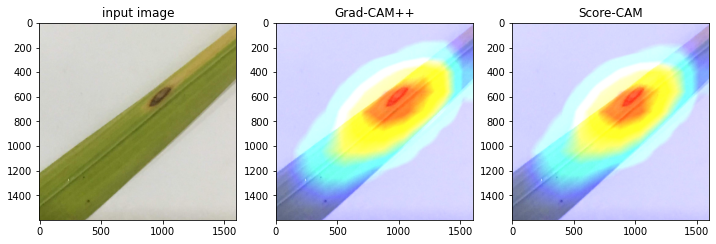

In [27]:

layer_name = 'block14_sepconv2_act'

#img_path = '/content/drive/MyDrive/bird.jpg'
img_path = '/content/drive/MyDrive/RiceLeaf/train/leaf_blast/leaf_blast (25).jpg'
orig_img = np.array(load_img(img_path),dtype=np.uint8)
img_array = read_and_preprocess_img(img_path, size=(299,299))

# predictions = model.predict(img_array)
# top = decode_predictions(predictions, top=5)[0]
# print(img_path)
# print("class activation map for:",top[0])

grad_cam_plus_plus=GradCamPlusPlus(model,img_array,layer_name)
grad_cam_plus_plus_superimposed = superimpose(img_path, grad_cam_plus_plus)

score_cam=ScoreCam(model,img_array,layer_name)
score_cam_superimposed = superimpose(img_path, score_cam)

fig, ax = plt.subplots(nrows=1,ncols=3, figsize=(12, 4))
ax[0].imshow(orig_img)
ax[0].set_title("input image")
ax[1].imshow(grad_cam_plus_plus_superimposed)
ax[1].set_title("Grad-CAM++")
ax[2].imshow(score_cam_superimposed)
ax[2].set_title("Score-CAM")

plt.show()

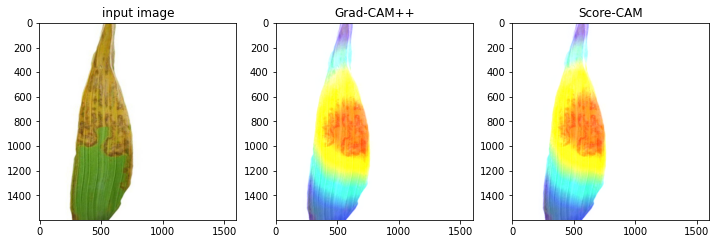

In [31]:

layer_name = 'block14_sepconv2_act'

#img_path = '/content/drive/MyDrive/bird.jpg'
img_path = '/content/drive/MyDrive/RiceLeaf/train/leaf_scald/leaf_scald (301).jpg'
orig_img = np.array(load_img(img_path),dtype=np.uint8)
img_array = read_and_preprocess_img(img_path, size=(299,299))

# predictions = model.predict(img_array)
# top = decode_predictions(predictions, top=5)[0]
# print(img_path)
# print("class activation map for:",top[0])

grad_cam_plus_plus=GradCamPlusPlus(model,img_array,layer_name)
grad_cam_plus_plus_superimposed = superimpose(img_path, grad_cam_plus_plus)

score_cam=ScoreCam(model,img_array,layer_name)
score_cam_superimposed = superimpose(img_path, score_cam)

fig, ax = plt.subplots(nrows=1,ncols=3, figsize=(12, 4))
ax[0].imshow(orig_img)
ax[0].set_title("input image")
ax[1].imshow(grad_cam_plus_plus_superimposed)
ax[1].set_title("Grad-CAM++")
ax[2].imshow(score_cam_superimposed)
ax[2].set_title("Score-CAM")

plt.show()

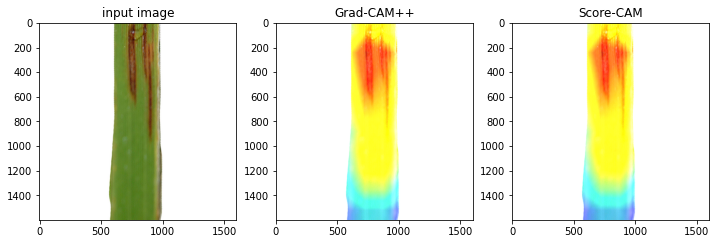

In [36]:

layer_name = 'block14_sepconv2_act'

#img_path = '/content/drive/MyDrive/bird.jpg'
img_path = '/content/drive/MyDrive/RiceLeaf/train/narrow_brown_spot/narrow_brown (267).jpg'
orig_img = np.array(load_img(img_path),dtype=np.uint8)
img_array = read_and_preprocess_img(img_path, size=(299,299))

# predictions = model.predict(img_array)
# top = decode_predictions(predictions, top=5)[0]
# print(img_path)
# print("class activation map for:",top[0])

grad_cam_plus_plus=GradCamPlusPlus(model,img_array,layer_name)
grad_cam_plus_plus_superimposed = superimpose(img_path, grad_cam_plus_plus)

score_cam=ScoreCam(model,img_array,layer_name)
score_cam_superimposed = superimpose(img_path, score_cam)

fig, ax = plt.subplots(nrows=1,ncols=3, figsize=(12, 4))
ax[0].imshow(orig_img)
ax[0].set_title("input image")
ax[1].imshow(grad_cam_plus_plus_superimposed)
ax[1].set_title("Grad-CAM++")
ax[2].imshow(score_cam_superimposed)
ax[2].set_title("Score-CAM")

plt.show()

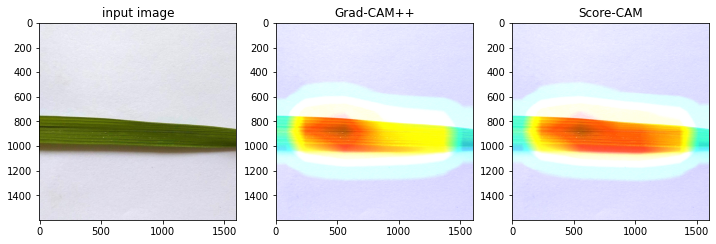

In [41]:

layer_name = 'block14_sepconv2_act'

#img_path = '/content/drive/MyDrive/bird.jpg'
img_path = '/content/drive/MyDrive/RiceLeaf/train/healthy/healthy (12).jpg'
orig_img = np.array(load_img(img_path),dtype=np.uint8)
img_array = read_and_preprocess_img(img_path, size=(299,299))

# predictions = model.predict(img_array)
# top = decode_predictions(predictions, top=5)[0]
# print(img_path)
# print("class activation map for:",top[0])

grad_cam_plus_plus=GradCamPlusPlus(model,img_array,layer_name)
grad_cam_plus_plus_superimposed = superimpose(img_path, grad_cam_plus_plus)

score_cam=ScoreCam(model,img_array,layer_name)
score_cam_superimposed = superimpose(img_path, score_cam)

fig, ax = plt.subplots(nrows=1,ncols=3, figsize=(12, 4))
ax[0].imshow(orig_img)
ax[0].set_title("input image")
ax[1].imshow(grad_cam_plus_plus_superimposed)
ax[1].set_title("Grad-CAM++")
ax[2].imshow(score_cam_superimposed)
ax[2].set_title("Score-CAM")

plt.show()